This include everything

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import random

In [15]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [16]:
def load_prot_t5_data(pos_file, neg_file):
    """Load ProtT5 embeddings and align with existing data"""
    # Read positive and negative files
    pos_data = []
    with open(pos_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            pos_data.append((entry, pos, embeddings))
            
    neg_data = []
    with open(neg_file, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            entry = parts[0]
            pos = int(parts[1])
            embeddings = [float(x) for x in parts[2:]]
            neg_data.append((entry, pos, embeddings))
    
    # Convert to dictionaries for easy lookup
    pos_dict = {(entry, pos): emb for entry, pos, emb in pos_data}
    neg_dict = {(entry, pos): emb for entry, pos, emb in neg_data}
    
    return pos_dict, neg_dict

In [17]:
def prepare_aligned_data(seq_struct_df, pos_dict, neg_dict):
    """Align ProtT5 embeddings with sequence+structure data"""
    embeddings = []
    aligned_indices = []
    
    for idx, row in seq_struct_df.iterrows():
        key = (row['entry'], row['pos'])
        emb = pos_dict.get(key) if row['label'] == 1 else neg_dict.get(key)
        
        if emb is not None:
            embeddings.append(emb)
            aligned_indices.append(idx)
    
    # Convert to numpy array
    X_prot_t5 = np.array(embeddings)
    
    # Get aligned sequence+structure data
    aligned_df = seq_struct_df.iloc[aligned_indices]
    
    return X_prot_t5, aligned_df

In [18]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [19]:
def prepare_structure_data(df):
    """Enhanced feature preparation focusing on important features"""
    features_list = []
    middle_pos = 16  # Center position
    
    # Helper function for normalization
    def normalize_angles(angle_array):
        angle_rad = np.pi * angle_array / 180.0
        return np.stack([np.sin(angle_rad), np.cos(angle_rad)], axis=-1)
    
    # 1. Most important features (importance > 0.04) - using ±0 window
    important_features = [
        'bfactor',
        'distance_to_center',
        'sasa',
        'omega',
        'domain_position'
    ]
    
    for feature in important_features:
        feature_arrays = np.array([np.array(eval(x)) for x in df[feature]])
        # Take only the center position
        center_values = feature_arrays[:, middle_pos]
        scaler = RobustScaler()
        scaled_values = scaler.fit_transform(center_values.reshape(-1, 1))
        features_list.append(scaled_values)
    
    # 2. Secondary important features (0.03 < importance < 0.04)
    secondary_features = [
        'chi1', 'chi2', 'chi3', 'chi4',
        'curvature', 'psi', 'phi', 'tau',
        'packing_density', 'local_hydrophobicity'
    ]
    
    for feature in secondary_features:
        feature_arrays = np.array([np.array(eval(x)) for x in df[feature]])
        center_values = feature_arrays[:, middle_pos]
        if feature in ['phi', 'psi', 'omega', 'tau']:
            # Angle features get sin/cos encoding
            angle_features = normalize_angles(center_values)
            features_list.append(angle_features)
        else:
            scaler = RobustScaler()
            scaled_values = scaler.fit_transform(center_values.reshape(-1, 1))
            features_list.append(scaled_values)
    
    # 3. Special case: hydrophobicity with ±1 window
    hydro_arrays = np.array([np.array(eval(x)) for x in df['hydrophobicity']])
    hydro_window = hydro_arrays[:, middle_pos-1:middle_pos+2]  # ±1 window
    scaler = RobustScaler()
    hydro_scaled = scaler.fit_transform(hydro_window.reshape(-1, 1)).reshape(len(hydro_arrays), 3)
    features_list.append(hydro_scaled)
    
    # Combine all features
    features = np.concatenate(features_list, axis=-1)
    
    # Add a dimension for the "sequence" length (1 for center position)
    features = features.reshape(features.shape[0], 1, -1)
    
    return features

In [20]:
def create_combined_model_with_prot_t5(seq_length=33, struct_features=None, struct_window=0):
    """Create model with sequence, structure, and ProtT5 tracks"""
    # Sequence track
    seq_input = tf.keras.layers.Input(shape=(seq_length,), name='sequence_input')
    x_seq = tf.keras.layers.Embedding(21, 21, input_length=seq_length)(seq_input)
    x_seq = tf.keras.layers.Reshape((seq_length, 21, 1))(x_seq)
    x_seq = tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)
    x_seq = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_seq)
    x_seq = tf.keras.layers.Flatten()(x_seq)
    x_seq = tf.keras.layers.Dense(32, activation='relu', name='seq_features')(x_seq)
    x_seq = tf.keras.layers.Dropout(0.2)(x_seq)

    # Structure track
    struct_input = tf.keras.layers.Input(shape=(1, struct_features), name='structure_input')
    x_struct = struct_input
    struct_dense_size = min(struct_features * 2, 128)
    
    x_struct = tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu')(x_struct)
    x_struct = tf.keras.layers.BatchNormalization()(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)
    x_struct = tf.keras.layers.Flatten()(x_struct)
    x_struct = tf.keras.layers.Dense(struct_dense_size, activation='relu')(x_struct)
    x_struct = tf.keras.layers.Dropout(0.2)(x_struct)

    # ProtT5 track
    prot_t5_input = tf.keras.layers.Input(shape=(1024,), name='prot_t5_input')
    x_prot_t5 = tf.keras.layers.Dense(256)(prot_t5_input)
    x_prot_t5 = tf.keras.layers.Dropout(0.4)(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dense(128, activation='relu')(x_prot_t5)
    x_prot_t5 = tf.keras.layers.Dropout(0.4)(x_prot_t5)

    # Create learnable weights layer for three tracks
    weight_layer = tf.keras.layers.Dense(3, activation='softmax', name='track_weights')
    track_weights = weight_layer(tf.keras.layers.Concatenate()([x_seq, x_struct, x_prot_t5]))

    # Apply weights
    weighted_seq = tf.keras.layers.Multiply(name='weighted_seq')([
        x_seq,
        tf.keras.layers.Lambda(lambda x: x[:, 0:1])(track_weights)
    ])
    
    weighted_struct = tf.keras.layers.Multiply(name='weighted_struct')([
        x_struct,
        tf.keras.layers.Lambda(lambda x: x[:, 1:2])(track_weights)
    ])
    
    weighted_prot_t5 = tf.keras.layers.Multiply(name='weighted_prot_t5')([
        x_prot_t5,
        tf.keras.layers.Lambda(lambda x: x[:, 2:3])(track_weights)
    ])

    # Combine features
    combined = tf.keras.layers.Concatenate()([weighted_seq, weighted_struct, weighted_prot_t5])

    # Final layers
    x = tf.keras.layers.Dense(32, activation='relu')(combined)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[seq_input, struct_input, prot_t5_input], outputs=outputs)

    def get_track_weights():
        w = model.get_layer('track_weights').get_weights()
        if len(w) > 0:
            weights = w[0]
            bias = w[1] if len(w) > 1 else 0
            exp_weights = np.exp(np.mean(weights, axis=0) + bias)
            normalized = exp_weights / np.sum(exp_weights)
            return {
                'sequence': float(normalized[0]),
                'structure': float(normalized[1]),
                'prot_t5': float(normalized[2])
            }
        return {'sequence': 0.33, 'structure': 0.33, 'prot_t5': 0.34}

    model.get_track_weights = get_track_weights
    return model

In [21]:
def train_and_evaluate():
    """Training function with track weights"""
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../data/processed_features_train_latest.csv")
    test_df = pd.read_csv("../data/processed_features_test_latest.csv")
    
    # Load ProtT5 embeddings
    print("Loading ProtT5 embeddings...")
    train_pos_dict, train_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/train/features/train_negative_ProtT5-XL-UniRef50.csv'
    )
    test_pos_dict, test_neg_dict = load_prot_t5_data(
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_positive_ProtT5-XL-UniRef50.csv',
        '/Users/hai/Workspace/UniFreiburg/WS2024/Thesis/LMSuccSite/data/test/features/test_negative_ProtT5-XL-UniRef50.csv'
    )
    
    # Align data
    print("Aligning data...")
    X_train_prot_t5, train_df_aligned = prepare_aligned_data(train_df, train_pos_dict, train_neg_dict)
    X_test_prot_t5, test_df_aligned = prepare_aligned_data(test_df, test_pos_dict, test_neg_dict)
    
    # Prepare other data
    X_train_seq = prepare_sequence_data(train_df_aligned)
    X_test_seq = prepare_sequence_data(test_df_aligned)
    X_train_struct = prepare_structure_data(train_df_aligned)
    X_test_struct = prepare_structure_data(test_df_aligned)
    
    y_train = train_df_aligned['label'].values
    y_test = test_df_aligned['label'].values
    
    # Print class distribution
    print("\nTraining set distribution:")
    print(train_df_aligned['label'].value_counts())
    print("\nTest set distribution:")
    print(test_df_aligned['label'].value_counts())
    
    # Print data shapes
    print("\nData shapes:")
    print(f"X_train_seq: {X_train_seq.shape}")
    print(f"X_train_struct: {X_train_struct.shape}")
    print(f"X_train_prot_t5: {X_train_prot_t5.shape}")
    print(f"X_test_seq: {X_test_seq.shape}")
    print(f"X_test_struct: {X_test_struct.shape}")
    print(f"X_test_prot_t5: {X_test_prot_t5.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"y_test: {y_test.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    # Cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    metrics = {'acc': [], 'balanced_acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    track_weights_history = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=3,
                min_lr=1e-6
            )
        ]
        
        # Create and compile model
        model = create_combined_model_with_prot_t5(
            seq_length=33,
            struct_features=X_train_struct.shape[2],
            struct_window=0
        )
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        history = model.fit(
            [X_train_seq[train_idx], X_train_struct[train_idx], X_train_prot_t5[train_idx]], 
            y_train[train_idx],
            validation_data=(
                [X_train_seq[val_idx], X_train_struct[val_idx], X_train_prot_t5[val_idx]], 
                y_train[val_idx]
            ),
            batch_size=32,
            epochs=50,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Evaluate on validation set
        y_pred = model.predict([X_train_seq[val_idx], X_train_struct[val_idx], X_train_prot_t5[val_idx]])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['balanced_acc'].append(balanced_accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))  # Sensitivity
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))  # Specificity
        
        # Predict on test set
        test_pred = model.predict([X_test_seq, X_test_struct, X_test_prot_t5])
        test_predictions.append(test_pred)
        
        # Print fold results
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
        
        # After training, get and store the learned weights
        final_weights = model.get_track_weights()
        track_weights_history.append(final_weights)
        print(f"\nLearned track weights for fold {fold}:")
        print(f"Sequence weight: {final_weights['sequence']:.4f}")
        print(f"Structure weight: {final_weights['structure']:.4f}")
        print(f"ProtT5 weight: {final_weights['prot_t5']:.4f}")
    
    # Calculate average weights
    avg_seq_weight = np.mean([w['sequence'] for w in track_weights_history])
    avg_struct_weight = np.mean([w['structure'] for w in track_weights_history])
    avg_prot_t5_weight = np.mean([w['prot_t5'] for w in track_weights_history])
    std_seq_weight = np.std([w['sequence'] for w in track_weights_history])
    std_struct_weight = np.std([w['structure'] for w in track_weights_history])
    std_prot_t5_weight = np.std([w['prot_t5'] for w in track_weights_history])
    
    print("\nAverage track weights across folds:")
    print(f"Sequence weight: {avg_seq_weight:.4f} ± {std_seq_weight:.4f}")
    print(f"Structure weight: {avg_struct_weight:.4f} ± {std_struct_weight:.4f}")
    print(f"ProtT5 weight: {avg_prot_t5_weight:.4f} ± {std_prot_t5_weight:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Loading data...
Loading ProtT5 embeddings...
Aligning data...

Training set distribution:
label
1    4591
0    4257
Name: count, dtype: int64

Test set distribution:
label
0    2497
1     240
Name: count, dtype: int64

Data shapes:
X_train_seq: (8848, 33)
X_train_struct: (8848, 1, 21)
X_train_prot_t5: (8848, 1024)
X_test_seq: (2737, 33)
X_test_struct: (2737, 1, 21)
X_test_prot_t5: (2737, 1024)
y_train: (8848,)
y_test: (2737,)

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.5989 - loss: 0.6592 - val_accuracy: 0.6927 - val_loss: 0.5876 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7010 - loss: 0.5780 - val_accuracy: 0.7040 - val_loss: 0.5724 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7215 - loss: 0.5522 - val_accuracy: 0.6949 - val_loss: 0.5883 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7382 - loss: 0.5323 - val_accuracy: 0.7040 - val_loss: 0.5714 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7388 - loss: 0.5170 - val_accuracy: 0.7141 - val_loss: 0.5856 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7621 - loss: 0.4968 - val_accuracy: 0.7186 - val_loss: 0.5811 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.7711 - l

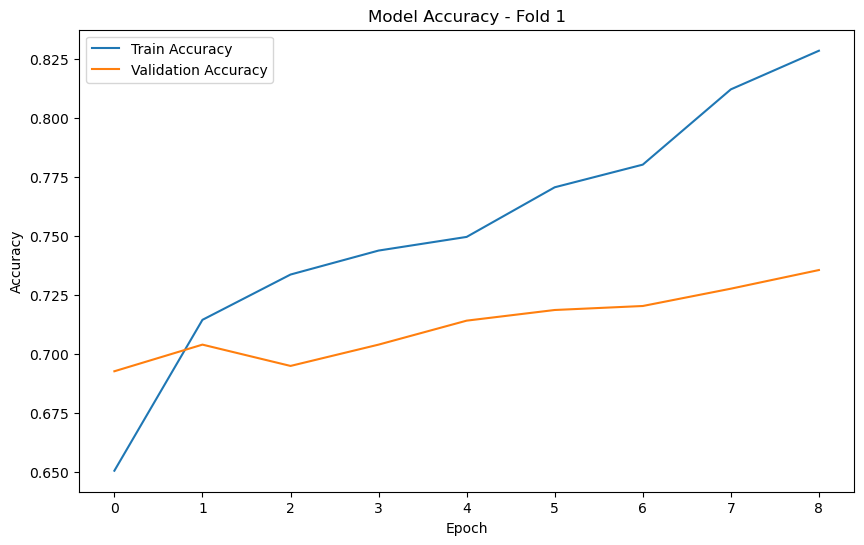

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Fold 1 Results:
Accuracy: 0.7040
Balanced Accuracy: 0.7013
MCC: 0.4091
Sensitivity: 0.7853
Specificity: 0.6173

Learned track weights for fold 1:
Sequence weight: 0.3217
Structure weight: 0.3258
ProtT5 weight: 0.3525

Fold 2/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.6077 - loss: 0.6514 - val_accuracy: 0.6893 - val_loss: 0.5944 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.7076 - loss: 0.5742 - val_accuracy: 0.7130 - val_loss: 0.5790 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.7374 - loss: 0.5343 - val_accuracy: 0.7282 - val_loss: 0.5586 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 65ms/step - accuracy: 0.7595 - loss: 0.5014 - val_accuracy: 0.7305 - val_loss: 0.5596 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.7729 - loss: 0.4665 - val_accuracy: 0.7508 - val_loss: 0.5442 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.8029 - loss: 0.4295 - val_accuracy: 0.7701 - val_loss: 0.5368 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.8322 - loss: 0.3906

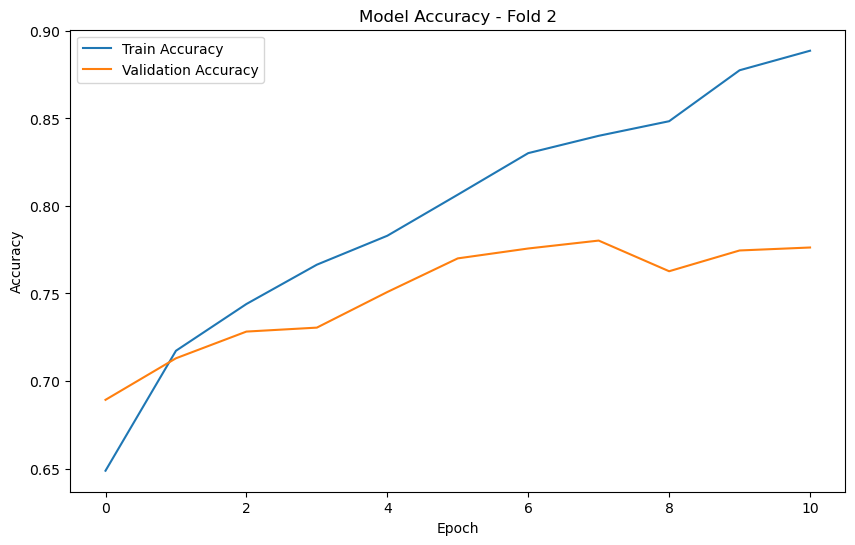

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Fold 2 Results:
Accuracy: 0.7701
Balanced Accuracy: 0.7683
MCC: 0.5376
Sensitivity: 0.7962
Specificity: 0.7403

Learned track weights for fold 2:
Sequence weight: 0.3391
Structure weight: 0.3178
ProtT5 weight: 0.3431

Fold 3/5
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.6127 - loss: 0.6525 - val_accuracy: 0.7011 - val_loss: 0.6014 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.6988 - loss: 0.5851 - val_accuracy: 0.7147 - val_loss: 0.5675 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.7314 - loss: 0.5471 - val_accuracy: 0.7311 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.7464 - loss: 0.5192 - val_accuracy: 0.7407 - val_loss: 0.5442 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.7677 - loss: 0.4916 - val_accuracy: 0.7605 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 64ms/step - accuracy: 0.7937 - loss: 0.4569 - val_accuracy: 0.7508 - val_loss: 0.5576 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.8007 - loss: 0.4348

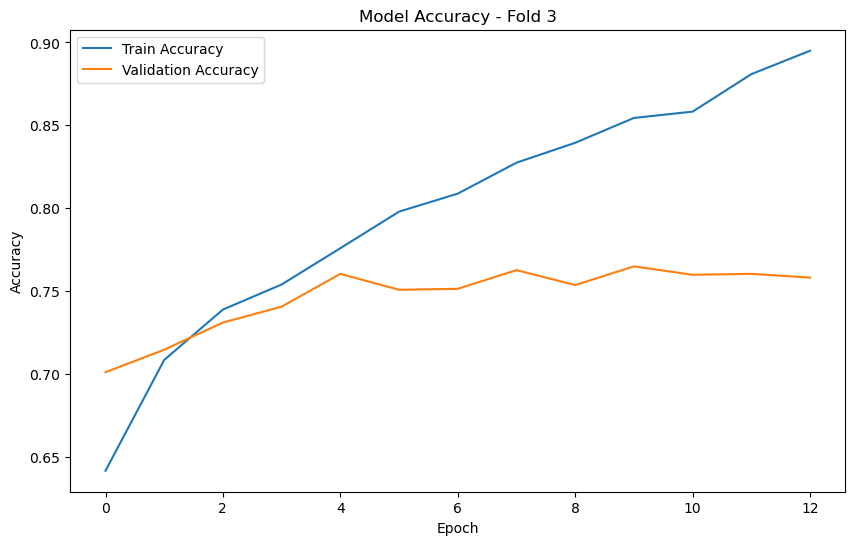

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Fold 3 Results:
Accuracy: 0.7627
Balanced Accuracy: 0.7619
MCC: 0.5253
Sensitivity: 0.7949
Specificity: 0.7289

Learned track weights for fold 3:
Sequence weight: 0.3471
Structure weight: 0.3160
ProtT5 weight: 0.3368

Fold 4/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.5873 - loss: 0.6621 - val_accuracy: 0.7049 - val_loss: 0.5684 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.6974 - loss: 0.5798 - val_accuracy: 0.7145 - val_loss: 0.5543 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.7291 - loss: 0.5452 - val_accuracy: 0.7258 - val_loss: 0.5497 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.7402 - loss: 0.5267 - val_accuracy: 0.7258 - val_loss: 0.5440 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 82ms/step - accuracy: 0.7466 - loss: 0.5026 - val_accuracy: 0.7253 - val_loss: 0.5500 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.7631 - loss: 0.4824 - val_accuracy: 0.7207 - val_loss: 0.5579 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.7767 - l

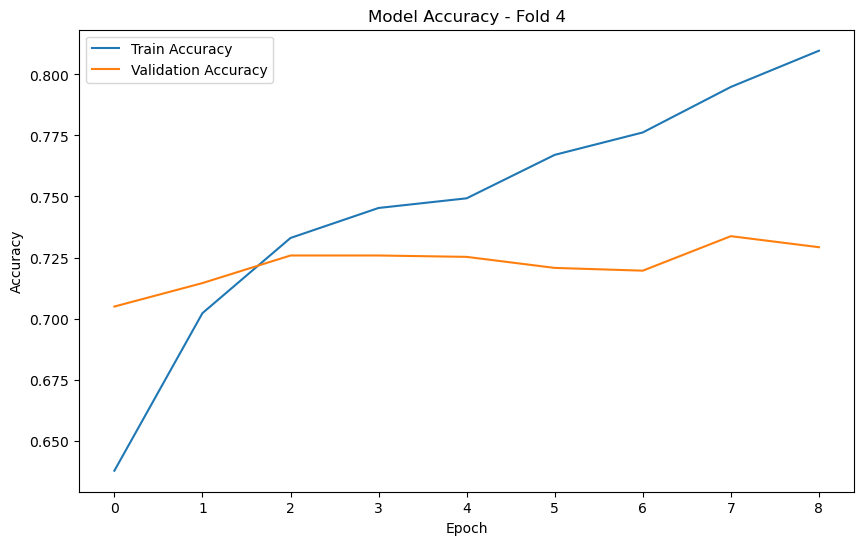

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Fold 4 Results:
Accuracy: 0.7258
Balanced Accuracy: 0.7227
MCC: 0.4560
Sensitivity: 0.8246
Specificity: 0.6208

Learned track weights for fold 4:
Sequence weight: 0.3231
Structure weight: 0.3270
ProtT5 weight: 0.3500

Fold 5/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.6084 - loss: 0.6495 - val_accuracy: 0.7145 - val_loss: 0.5702 - learning_rate: 0.0010
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step - accuracy: 0.7110 - loss: 0.5669 - val_accuracy: 0.7202 - val_loss: 0.5534 - learning_rate: 0.0010
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.7279 - loss: 0.5364 - val_accuracy: 0.7230 - val_loss: 0.5542 - learning_rate: 0.0010
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 16s 74ms/step - accuracy: 0.7441 - loss: 0.5158 - val_accuracy: 0.7349 - val_loss: 0.5535 - learning_rate: 0.0010
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - accuracy: 0.7577 - loss: 0.5052 - val_accuracy: 0.7298 - val_loss: 0.5495 - learning_rate: 0.0010
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - accuracy: 0.7626 - loss: 0.4830 - val_accuracy: 0.7309 - val_loss: 0.5411 - learning_rate: 0.0010
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 14s 63ms/step - accuracy: 0.7826 - l

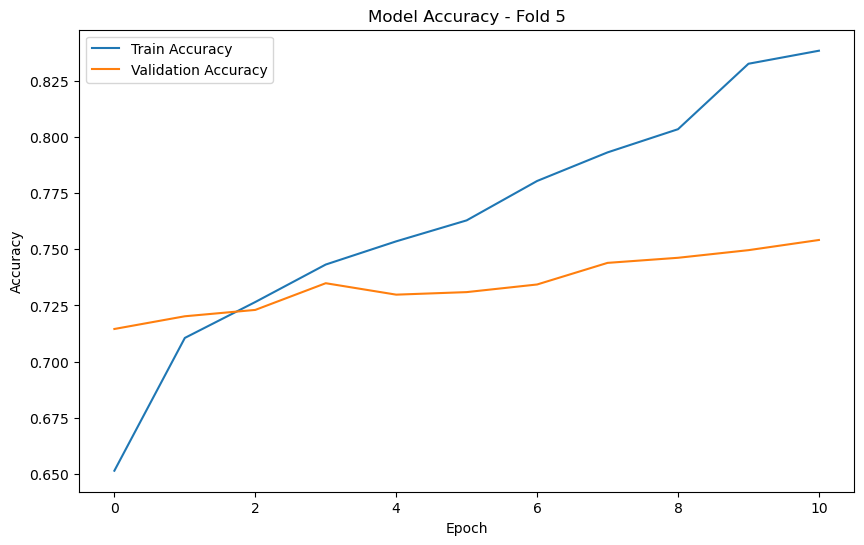

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

Fold 5 Results:
Accuracy: 0.7309
Balanced Accuracy: 0.7291
MCC: 0.4610
Sensitivity: 0.7786
Specificity: 0.6796

Learned track weights for fold 5:
Sequence weight: 0.3177
Structure weight: 0.3289
ProtT5 weight: 0.3534

Average track weights across folds:
Sequence weight: 0.3297 ± 0.0114
Structure weight: 0.3231 ± 0.0052
ProtT5 weight: 0.3472 ± 0.0063

Average Cross-validation Results:
ACC: 0.7387 ± 0.0245
BALANCED_ACC: 0.7366 ± 0.0251
MCC: 0.4778 ± 0.0475
SN: 0.7959 ± 0.0157
SP: 0.6774 ± 0.0518

Final Test Set Results:
Accuracy: 0.7117
Balanced Accuracy: 0.7629
MCC: 0.3128
Sensitivity: 0.8250
Specificity: 0.7008
Confusion Matrix:
[[1750  747]
 [  42  198]]


In [22]:
if __name__ == "__main__":
    model = train_and_evaluate()